In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import scipy.stats
import numpyro.distributions as dist

def C_numerical(t, q, n):
    p = jax.scipy.special.expit(t)
    xs = jnp.arange(n + 1)
    return jnp.exp(jax.scipy.special.logsumexp(
        q * jnp.log(jnp.abs(xs - n * p))
        + dist.Binomial(n, p).log_prob(xs)
    ))
Cn = jax.jit(jax.vmap(C_numerical, in_axes=(0, None, None)), static_argnums=(2,))
Cng = jax.jit(jax.vmap(jax.grad(C_numerical), in_axes=(0, None, None)), static_argnums=(2,))

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 10
q = 1.2

In [3]:
p = 0.4501
xs = np.arange(n + 1)
CS = np.sign(xs - n * p)
x1 = int(np.floor(p * n))
x2 = x1 + 1

def C_numerical_fixed(t, q, n):
    p = jax.scipy.special.expit(t)
    xs = jnp.arange(n + 1)
    return jnp.exp(jax.scipy.special.logsumexp(
        q * jnp.log(CS * (xs - n * p))
        + dist.Binomial(n, p).log_prob(xs)
    ))

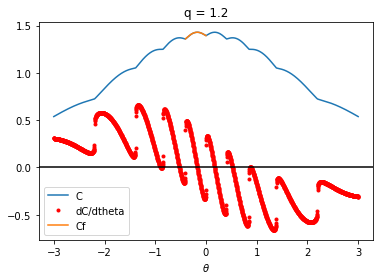

In [4]:
domain = [-3, 3]
ts = np.linspace(-3, 3, 2000)
ps = jax.scipy.special.expit(ts)
cs = Cn(ts, q, n)
plt.title(f"q = {q}")
plt.plot(ts, cs, label="C")
cgs = Cng(ts, q, n)
plt.plot(ts, cgs, 'r.', label="dC/dtheta")

cs_fixed = jax.vmap(C_numerical_fixed, in_axes=(0, None, None))(ts, q, n)
plt.plot(ts, cs_fixed, label="Cf")
plt.axhline(0, color='black')
plt.legend()
plt.xlabel(r"$\theta$")
plt.show()

In [5]:
def C_numericalp(p, q, n):
    xs = jnp.arange(n + 1)
    return jnp.exp(jax.scipy.special.logsumexp(
        q * jnp.log(jnp.abs(xs - n * p))
        + dist.Binomial(n, p).log_prob(xs)
    ))
Cnpg = jax.jit(jax.vmap(jax.grad(C_numericalp), in_axes=(0, None, None)), static_argnums=(2,))

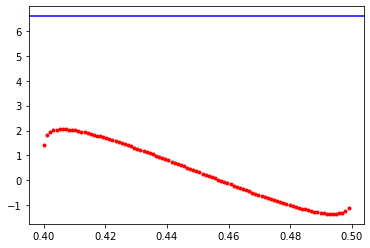

In [6]:
ps = np.linspace(x1 / n + 1e-4, x2 / n, 100)
MM = 0
AA = 0
for i in range(n + 1):
    pmf = lambda p: jnp.exp(dist.Binomial(n, p).log_prob(i))
    dpmf = jax.vmap(jax.grad(pmf))

    full = lambda p: (CS[i] * (i - n * p)) ** q * pmf(p)
    dfull = jax.vmap(jax.grad(full))

    t1 = q * (CS[i] * (i - n * ps)) ** (q - 1) * (-CS[i] * n) * pmf(ps)
    AA += t1
    t2 = (CS[i] * (i - n * ps)) ** q * dpmf(ps)
    d = t1 + t2
    d2 = dfull(ps)
    # np.testing.assert_allclose(d, d2, atol=1e-4)
    MM += np.max(d)
    
     
    # plt.plot(ps, d, label=f"i = {i}")
plt.axhline(MM, color='b')
plt.plot(ps, Cnpg(ps, q, n), 'r.')
plt.show()

In [7]:
xs = np.arange(n + 1)
pmf = lambda p: jnp.exp(dist.Binomial(n, p).log_prob(xs))
ppp = 0.475
np.sum(pmf(ppp) * CS * np.abs(xs - n * ppp) ** (q - 1) * ((xs - n * ppp) ** 2 / (ppp * (1 - ppp)) - q * n))

DeviceArray(-0.8033765, dtype=float32)

In [53]:
ps = np.array([x1 / n, x2/n])
# ps = np.linspace(x1 / n, x2 / n, 100)
pmf_max = np.max(jax.vmap(pmf)(ps), axis=0)
bracket_max = np.max(CS[None] * ((xs[None] - n * ps[:,None]) ** 2 / (ps[:, None] * (1 - ps[:, None])) - q * n), axis=0)
pow_max = np.max(np.abs(xs[None] - n * ps[:, None]), axis=0) ** (q - 1)
np.sum(bracket_max * pow_max * pmf_max)

DeviceArray(9.927755, dtype=float32)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_94739/2140881920.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(ps, (xs[None, ::3] - n * ps[:,None]) ** 2 / (ps[:, None] * (1 - ps[:, None])) - q * n)
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_94739/2140881920.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(ps, (xs[None, ::3] - n * ps[:,None]) ** 2 / (ps[:, None] * (1 - ps[:, None])) - q * n)


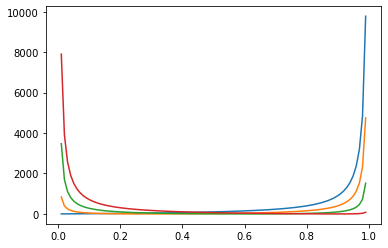

In [58]:
ps = np.linspace(0, 1, 100)
plt.plot(ps, (xs[None, ::3] - n * ps[:,None]) ** 2 / (ps[:, None] * (1 - ps[:, None])) - q * n)
plt.show()

In [19]:
xs / (2 * xs - n)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_94739/824325314.py:1: RuntimeWarning: divide by zero encountered in divide
  xs / (2 * xs - n)


array([-0.        , -0.125     , -0.33333333, -0.75      , -2.        ,
               inf,  3.        ,  1.75      ,  1.33333333,  1.125     ,
        1.        ])

In [31]:
ppp = 0.45
QQ = 5.0
PP = 1.0 / (1 - 1.0 / QQ)
m1 = np.sum(pmf(ppp) * (np.abs(xs - n * ppp) ** (q - 1)) ** QQ) ** (1 / QQ)
m2 = np.sum(pmf(ppp) * (np.abs(((xs - n * ppp) ** 2 / (ppp * (1 - ppp)) - q * n)) ** PP)) ** (1 / PP)
m1*m2

DeviceArray(11.566728, dtype=float32)

In [21]:
Cnpg(np.array([ppp]), q, n)

DeviceArray([-0.80337703], dtype=float32)

In [227]:
ppp = 0.451
xs = np.arange(n + 1)
np.sum((xs - n * ppp) ** 2 * scipy.stats.binom.pmf(xs, n, ppp))

24.75989999999999

In [228]:
px1 = np.maximum(np.min(ps) ** (xs - 1), np.max(ps) ** (xs - 1))
opnx1 = np.maximum(np.min(ps) ** (n - xs - 1), np.max(ps) ** (n - xs - 1))
xnp = np.maximum(xs - n * np.min(ps), xs - n * np.max(ps))
dpdp = scipy.special.comb(n, xs) * px1 * opnx1 * xnp

In [229]:
xs = np.arange(n + 1)
pmf = lambda p: jnp.exp(dist.Binomial(n, p).log_prob(xs))
pmf_max = np.maximum(pmf(np.min(ps)), pmf(np.max(ps)))
t1 = np.maximum(
    q * (-n * CS) * (CS * (xs - n * np.min(ps))) ** (q - 1) * pmf_max,
    q * (-n * CS) * (CS * (xs - n * np.max(ps))) ** (q - 1) * pmf_max,
)
t2 = np.maximum(
    (CS * (xs - n * np.min(ps))) ** q * dpdp,
    (CS * (xs - n * np.max(ps))) ** q * dpdp
)
np.sum(t1 + t2)

14.018645287971157

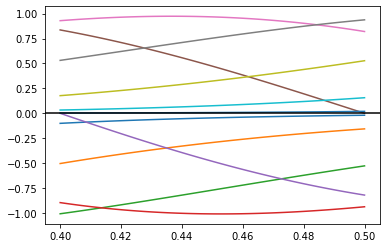

In [161]:
ps = np.linspace(x1 / n, x2 / n, 100)
# ps = np.linspace(0, 0.5, 100)
for i in range(n + 1):
    pmf = lambda p: jnp.exp(dist.Binomial(n, p).log_prob(i))
    dpmf = jax.vmap(jax.grad(pmf))
    plt.plot(ps, dpmf(ps), label=f"x = {i}")
plt.axhline(0, color='black')
plt.show()

## Archive

In [ ]:
t = -1.1
q = 1.2
p = jax.scipy.special.expit(t)
xs = jnp.arange(n + 1).astype(jnp.float64)
out2 = jnp.exp((1 / q) * jax.scipy.special.logsumexp(
    q * jnp.log(jnp.abs(dg_vmap(t, xs)))
    + dist.Binomial(n, p).log_prob(xs)
))

eggq = jnp.abs(dg_vmap(t, xs)) ** q
binom_pmf = jnp.exp(dist.Binomial(n, p).log_prob(xs))
sum(eggq * binom_pmf) ** (1 / q), out2, C_numerical(t, q)
n = 50

# for each scallop
# we know pmin, pmax. determine CS as above.
# find the maximum of each term here: 
# sum those maximums.
t1 = q * (-CS * n) * (CS * x - CS * n * p) ** (q - 1) * (p ** x) * ((1 - p) ** (n - x))
t2 = (CS * x - CS * n * p) ** q * x * (p**(x - 1)) * ((1 - p) ** (n - x))
t3 = (CS * x - CS * n * p) ** q * (p**x) * (n - x) * (-1) * ((1 - p) ** (n - x - 1))
scipy.special.comb(n, x) * (t1 + t2 + t3)
np.sum(
    (
        scipy.special.comb(n, x)
        * (CS * (x - n * p)) ** q
        * (p**x)
        * ((1 - p) ** (n - x))
    )
) ** (1 / hq)

n = 50
p = 0.45
x = np.arange(n + 1)
hq = 1.2
x_range = (12, 13)
SC = np.sign(xs - n * p)
FF = (SC * x - SC * n * p) ** hq * (p ** x) * ((1 - p) ** (n - x))
ps = np.linspace(12/n, 13/n, 100)
hq * np.log(SC * x[None, :] - SC * n * ps[:, None]) + x[None, :] * np.log(ps[:, None]) + (n - x[None, :]) * np.log(1 - ps[:, None])
# np.sum((scipy.special.comb(n, x) * (C * (x - n * p)) ** hq * (p ** x) * ((1 - p) ** (n - x)))) ** (1 / hq)
plot_q_theta(1.2, domain=[-0.3, -0.28])
plt.show()
q = 1.2
xs_all = jnp.arange(n + 1).astype(jnp.float64)
plt.figure(figsize=(10,10))
for t in np.linspace(-2, -0.2, 19):
    domain = np.array([t - 0.1, t + 0.1])
    pdomain = jax.scipy.special.expit(domain)
    pworst = pdomain[np.argmax(np.abs(pdomain))]

    bad_x_range = jnp.arange(int(np.ceil(n*pdomain[0])), int(np.floor(n*pdomain[1])) + 1)
    xs_base = jnp.setdiff1d(xs_all, bad_x_range)

    all_max = np.sum(np.max(np.abs(xs_all[None, :] - n * pdomain[:, None]) ** q * scipy.stats.binom.pmf(xs_all, n, pdomain[:, None]), axis=0)) ** (1/q)

    split_max = (
        np.sum(np.max(np.abs(bad_x_range[None, :] - n * pdomain[:, None]) ** q * scipy.stats.binom.pmf(bad_x_range, n, pdomain[:, None]), axis=0))
        + np.sum(np.abs(xs_base - n * pworst) ** q * scipy.stats.binom.pmf(xs_base, n, pworst))
    ) ** (1/q)

    simple_edge = np.sum(np.abs(xs_all - n * pworst) ** q * scipy.stats.binom.pmf(xs_all, n, pworst)) ** (1/q)

    # plt.plot(domain, [all_max, all_max], 'r:', label="all")
    plt.plot(domain, [split_max, split_max], 'r-', label="split")
    plt.plot(domain, [simple_edge, simple_edge], 'm:', label="simple")

    ts = np.linspace(*domain, 1000)
    cs = jax.jit(jax.vmap(C_numerical, in_axes=(0, None)))(ts, q)
    plt.title(f"q = {q}")
    plt.plot(ts, cs, 'k-')
plt.show()
# Let's construct a curve $C_e(\theta)$ that has the property that:

# $$
# C(\theta_{l}) \leq C_e(\theta) ~~ \forall ~~ \theta_{l} < \theta
# $$
start_theta = scipy.special.logit(np.arange(1, n) / n)
join = []
j = 0
left_f = C_numerical(start_theta[j], 1.2)
right_f = C_numerical(start_theta[j + 1], 1.2)
slope = (right_f - left_f) / (start_theta[j + 1] - start_theta[j])
opt = scipy.optimize.minimize_scalar(
    lambda t: -(C_numerical(t, 1.2) - (left_f + slope * (t - start_theta[j]))),
    bounds = (start_theta[j], start_theta[j+1]),
    method = "bounded",
)
join.append((opt['x'], C_numerical(opt['x'], 1.2)))

for j in range(start_theta.shape[0] - 1):
    opt = scipy.optimize.minimize_scalar(
        lambda t: -(C_numerical(t, 1.2) - join[-1][1]) / (t - join[-1][0]),
        bounds = (start_theta[j], start_theta[j+1]),
        method = "bounded",
    )
    # print(opt['x'], opt['x'] - start_theta[j : (j+2)])
    join.append((opt['x'], C_numerical(opt['x'], 1.2)))
join = np.array(join)
plt.figure(figsize=(3,3))
ts = np.linspace(-2.5, 2.5, 1000)
cs = jax.jit(jax.vmap(C_numerical, in_axes=(0, None)))(ts, q)
plt.title(f"q = {q}")
plt.plot(ts, cs, label="C")
cgs = jax.jit(jax.vmap(jax.grad(C_numerical), in_axes=(0, None)))(ts, q)
cggs = jax.jit(jax.vmap(jax.grad(jax.grad(C_numerical)), in_axes=(0, None)))(ts, q)
plt.plot(join[:,0], join[:,1], 'k-o')
# plt.plot(ts, cgs, label="dC/dtheta")
# plt.plot(ts, cggs, label="d2C/dtheta2")
# abs_pts = scipy.special.logit(np.arange(1, n) / n)
# for t in abs_pts:
#     plt.axvline(t, color='black', linewidth=0.5)
# plt.ylim([-1, 4])
plt.xlim([np.min(ts), np.max(ts)])
plt.ylim([np.min(cs), np.max(cs)])
plt.legend()
plt.xlabel(r"$\theta$")
plt.show()

(DeviceArray(2.58610127, dtype=float64),
 DeviceArray(2.58610127, dtype=float64),
 DeviceArray(2.58610127, dtype=float64))